In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

In [2]:
import os
print(os.getcwd())  # 获取当前工作目录

d:\研究生\研一上\组会\ML小组\lecture2


## 1. 生成模拟数据

有效特征为 x0-x7，其中 x0, x1 高度相关，x2-x4 高度相关。

In [ ]:
# 参数
n_samples, n_features, n_informative = 1000, 20, 8
noise = 10.0
random_state = 42
rng = np.random.RandomState(random_state)

# 1. 生成独立的 informative 特征
X_informative = rng.normal(size=(n_samples, n_informative))

# 让前两列高度相关（corr ~ 0.95）
X_informative[:, 1] = X_informative[:, 0] * 0.95 + rng.normal(scale=0.05, size=n_samples)

# 让第3、4、5列高度相关（corr ~ 0.95）
X_informative[:, 3] = X_informative[:, 2] * 0.95 + rng.normal(scale=0.05, size=n_samples)
X_informative[:, 4] = X_informative[:, 2] * 0.95 + rng.normal(scale=0.05, size=n_samples)

# 其余3个 informative 特征保持独立（列6、7、8）
# X_informative[:, 5:8] 已经独立

# 2. 生成噪声特征
X_noise = rng.normal(size=(n_samples, n_features - n_informative))

# 3. 拼接成完整特征矩阵
X = np.hstack([X_informative, X_noise])

# 4. 生成目标变量 y
# 设置真实系数：前8个 informative 特征有非零系数，其余为0
coef_true = np.zeros(n_features)
coef_true[:n_informative] = rng.uniform(1.0, 10.0, size=n_informative)

Y = X.dot(coef_true) + rng.normal(scale=noise, size=n_samples)

# 5. 生成特征名
feature_names = np.array([f"x{j}" for j in range(n_features)])


In [5]:
# 划分训练集和测试集，标准化
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# 创建标准化器
scaler = StandardScaler()

# 在训练集上拟合并转换
X_train_scaled = scaler.fit_transform(X_train)

# 使用训练集的均值和标准差来转换测试集
X_test_scaled = scaler.transform(X_test)

## 2. 线性回归

In [9]:
# 线性回归

# 初始化线性回归模型
model = LinearRegression()

# 训练模型
model.fit(X_train_scaled, Y_train)

# 使用测试集进行预测
linear_pred = model.predict(X_test_scaled)

# 评估模型的性能：MSE，RMSE，R2
linear_mse = mean_squared_error(Y_test, linear_pred)
linear_rmse = np.sqrt(linear_mse)
linear_r2 = r2_score(Y_test, linear_pred)
print(f"线性回归的MSE: {linear_mse}")
print(f"线性回归的RMSE: {linear_rmse}")
print(f"线性回归的R2: {linear_r2}")

线性回归的MSE: 98.95517121882266
线性回归的RMSE: 9.94762138497554
线性回归的R2: 0.8620763014521149


## 3. 岭回归

In [10]:
# 岭回归，选择超参数α（L2惩罚项）
alphas = np.logspace(-3, 3, 50)  # 搜索范围从 0.001 到 1000
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_scaled, Y_train) # 同时完成训练和交叉验证
ridge_pred = ridge_cv.predict(X_test_scaled)

# 输出最优 alpha
print(f"最佳Ridge回归α值: {ridge_cv.alpha_}")

# 评估模型的性能：MSE，RMSE，R2
ridge_mse = mean_squared_error(Y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(Y_test, ridge_pred)
print(f"Ridge的MSE: {ridge_mse}")
print(f"Ridge的RMSE: {ridge_rmse}")
print(f"Ridge的R2: {ridge_r2}")

最佳Ridge回归α值: 10.985411419875572
Ridge的MSE: 98.9610211815862
Ridge的RMSE: 9.94791541889989
Ridge的R2: 0.8620681477751441


## 4. Lasso

In [15]:
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, Y_train)
lasso_pred = lasso_cv.predict(X_test_scaled)

# 输出最优 alpha 
print(f"最佳Lasso回归α值: {lasso_cv.alpha_}")

# 计算非零系数的数量
nz_mask = lasso_cv.coef_ != 0.0
print(f"入选变量数: {nz_mask.sum()} / {len(feature_names)}")

# 评估模型性能
lasso_mse = mean_squared_error(Y_test, lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(Y_test, lasso_pred)

print(f"Lasso的MSE: {lasso_mse}")
print(f"Lasso的RMSE: {lasso_rmse}")
print(f"Lasso的R2: {lasso_r2}")

最佳Lasso回归α值: 0.23899520892004975
入选变量数: 13 / 20
Lasso的MSE: 97.03488656323907
Lasso的RMSE: 9.850628739488615
Lasso的R2: 0.8647527938344803


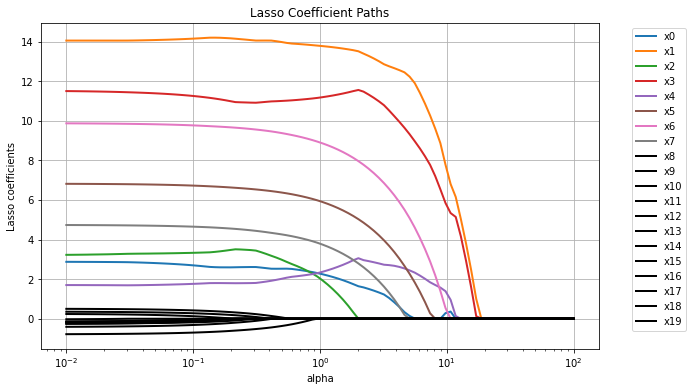

In [ ]:
# 生成一系列 alpha 值（从大到小，越小正则化越弱）
alphas = np.logspace(-2, 2, 100)

# 存储系数
coefs = []

# 对每个 alpha 拟合 Lasso 并记录系数
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_scaled, Y_train)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

# 绘图
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    # 判断是否是 x8 ~ x19
    if 8 <= i <= 19:
        plt.plot(alphas, coefs[:, i], color='black', linewidth=2, label=f'{feature_names[i]}')
    else:
        plt.plot(alphas, coefs[:, i], linewidth=2, label=f'{feature_names[i]}')

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Lasso coefficients')
plt.title('Lasso Coefficient Paths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.savefig("Lasso_path.png", bbox_inches="tight")
plt.show()



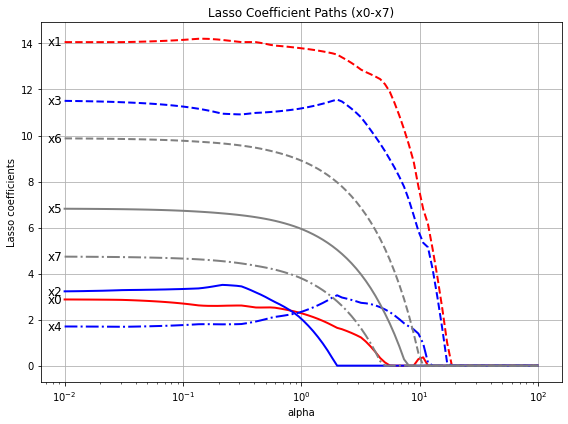

In [53]:
# 生成一系列 alpha 值（从大到小，越小正则化越弱）
alphas = np.logspace(-2, 2, 100)

# 存储系数
coefs = []

# 对每个 alpha 拟合 Lasso 并记录系数
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_scaled, Y_train)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

# 定义不同变量的线型
linestyles = ["-", "--", "-."]

# 绘图 (只画 x0-x4)
plt.figure(figsize=(8, 6))

for i in range(8):  # 只画前 5 个变量
    if i in [0, 1]:
        color = "red"
        linestyle=linestyles[i]
    elif i in [2, 3, 4]:
        color = "blue"
        linestyle=linestyles[i-2]
    else:
        color = "gray"
        linestyle=linestyles[i-5]
    plt.plot(
        alphas, coefs[:, i],
        color=color,
        linestyle=linestyle,
        linewidth=2,
        label=f"x{i}"
    )

    # 在线的最左边标注变量名
    plt.text(
        alphas[0] * 0.95,  # 稍微左移
        coefs[0, i],
        f"x{i}",
        fontsize=12,
        color="black",
        va="center",
        ha="right"
    )

plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Lasso coefficients")
plt.title("Lasso Coefficient Paths (x0-x7)")
plt.grid(True)
plt.tight_layout()
plt.savefig("Lasso_path1.png", bbox_inches="tight")
plt.show()

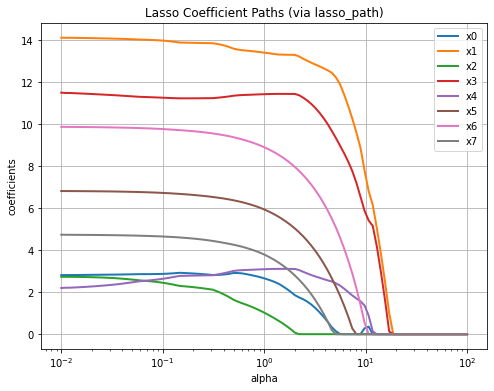

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path

# 使用 lasso_path 计算路径
# 注意：X_train_scaled, Y_train 已经准备好
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, Y_train, alphas=np.logspace(-2, 2, 100))

# 绘制 Lasso 系数路径
plt.figure(figsize=(8, 6))
for i in range(min(8, coefs_lasso.shape[0])):  # 只画前 8 个特征，避免太乱
    plt.plot(alphas_lasso, coefs_lasso[i, :], label=f"x{i}", linewidth=2)

plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso Coefficient Paths (via lasso_path)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## 5. 弹性网络

In [28]:
# 拟合弹性网络回归
elastic_cv = ElasticNetCV(
    l1_ratio=[.1, .3, .5, .7, .9, .95, .99, 1],  # L1/L2 比例候选值
    cv=5,
    random_state=42
)
elastic_cv.fit(X_train_scaled, Y_train)
elastic_pred = elastic_cv.predict(X_test_scaled)

# 输出最优参数
print(f"最佳ElasticNet α值: {elastic_cv.alpha_}")
print(f"最佳ElasticNet l1_ratio值: {elastic_cv.l1_ratio_}")

# 计算非零系数的数量
nz_mask = elastic_cv.coef_ != 0.0
print(f"入选变量数: {nz_mask.sum()} / {len(feature_names)}")

# 评估模型性能
elastic_mse = mean_squared_error(Y_test, elastic_pred)
elastic_rmse = np.sqrt(elastic_mse)
elastic_r2 = r2_score(Y_test, elastic_pred)

print(f"ElasticNet的MSE: {elastic_mse}")
print(f"ElasticNet的RMSE: {elastic_rmse}")
print(f"ElasticNet的R2: {elastic_r2}")

最佳ElasticNet α值: 0.2414093019394442
最佳ElasticNet l1_ratio值: 0.99
入选变量数: 13 / 20
ElasticNet的MSE: 97.07683047329583
ElasticNet的RMSE: 9.852757506063764
ElasticNet的R2: 0.8646943324207377


In [58]:
# 回归系数，整理成 DataFrame
coef_df = pd.DataFrame({
    "feature": feature_names,
    "linear_coef": model.coef_,
    "ridge_coef": ridge_cv.coef_,
    "lasso_coef": lasso_cv.coef_,
    "elastic_coef": elastic_cv.coef_,
    "true_coef": coef_true
})

print(coef_df)

   feature  linear_coef  ridge_coef  lasso_coef  elastic_coef  true_coef
0       x0     2.761700    7.966332    3.303334      6.262988   7.455734
1       x1    14.181491    8.864605   13.430547     10.456534   9.819827
2       x2     2.533653    5.299888    5.273899      4.726233   2.381397
3       x3    11.698773    6.184366   10.227508      8.086659   9.342286
4       x4     2.212447    4.874524    0.730595      3.403164   5.701276
5       x5     6.826731    6.748868    6.600541      6.593760   6.788962
6       x6     9.886913    9.717999    9.632548      9.595556   8.900821
7       x7     4.744223    4.686118    4.520073      4.513061   4.686888
8       x8     0.362015    0.378671    0.157604      0.166747   0.000000
9       x9    -0.154569   -0.149814   -0.000000     -0.000000   0.000000
10     x10     0.250574    0.261920    0.000000      0.000000   0.000000
11     x11    -0.418977   -0.411667   -0.176947     -0.177602   0.000000
12     x12     0.508148    0.493926    0.298722    

In [68]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge", "Lasso", "ElasticNet (l1_ratio=0.99)"],
    "MSE": [linear_mse, ridge_mse, lasso_mse, elastic_mse],
    "RMSE": [linear_rmse, ridge_rmse, lasso_rmse, elastic_rmse],
    "R²": [linear_r2, ridge_r2, lasso_r2, elastic_r2]
})

print(results)

                        Model        MSE      RMSE        R²
0           Linear Regression  98.955171  9.947621  0.862076
1                       Ridge  98.961021  9.947915  0.862068
2                       Lasso  97.034887  9.850629  0.864753
3  ElasticNet (l1_ratio=0.99)  97.076830  9.852758  0.864694


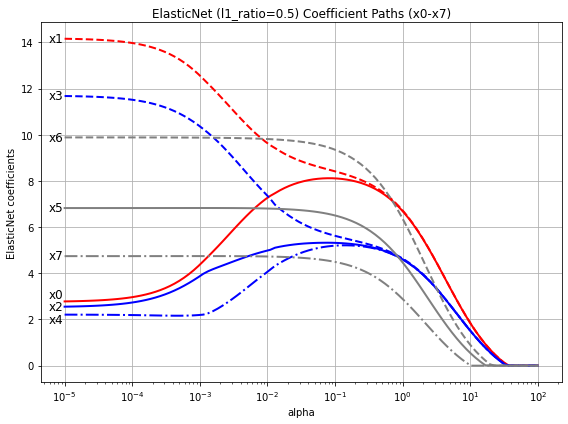

In [55]:
# 生成一系列 alpha 值
alphas = np.logspace(-5, 2, 100)

# 存储系数
coefs = []

# 对每个 alpha 拟合 ElasticNet 并记录系数
for a in alphas:
    enet = ElasticNet(alpha=a, l1_ratio=0.5, max_iter=10000)
    enet.fit(X_train_scaled, Y_train)
    coefs.append(enet.coef_)

coefs = np.array(coefs)

# 定义不同变量的线型
linestyles = ["-", "--", "-."]

# 绘图 (只画 x0-x7)
plt.figure(figsize=(8, 6))

for i in range(8):  
    if i in [0, 1]:
        color = "red"
        linestyle = linestyles[i]
    elif i in [2, 3, 4]:
        color = "blue"
        linestyle = linestyles[i-2]
    else:
        color = "gray"
        linestyle = linestyles[i-5]
    plt.plot(
        alphas, coefs[:, i],
        color=color,
        linestyle=linestyle,
        linewidth=2,
        label=f"x{i}"
    )

    # 在线的最左边标注变量名
    if i==0: 
        plt.text(
            alphas[0] * 0.95,
            coefs[0, i]+0.3,
            f"x{i}",
            fontsize=12,
            color="black",
            va="center",
            ha="right"
        )
    elif i==4: 
        plt.text(
            alphas[0] * 0.95,
            coefs[0, i]-0.2,
            f"x{i}",
            fontsize=12,
            color="black",
            va="center",
            ha="right"
        )
    else:
        plt.text(
            alphas[0] * 0.95,
            coefs[0, i],
            f"x{i}",
            fontsize=12,
            color="black",
            va="center",
            ha="right"
        )

plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("ElasticNet coefficients")
plt.title("ElasticNet (l1_ratio=0.5) Coefficient Paths (x0-x7)")
plt.grid(True)
plt.tight_layout()
plt.savefig("Elastic_path(l1=0.5).png", bbox_inches="tight")
plt.show()


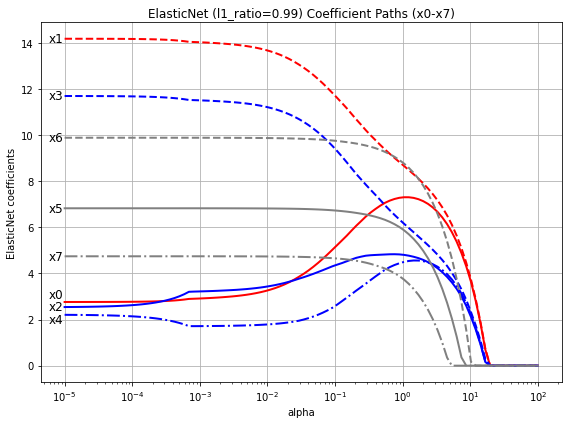

In [67]:
# 生成一系列 alpha 值
alphas = np.logspace(-5, 2, 100)

# 存储系数
coefs = []

# 对每个 alpha 拟合 ElasticNet 并记录系数
for a in alphas:
    enet = ElasticNet(alpha=a, l1_ratio=0.99, max_iter=10000)
    enet.fit(X_train_scaled, Y_train)
    coefs.append(enet.coef_)

coefs = np.array(coefs)

# 定义不同变量的线型
linestyles = ["-", "--", "-."]

# 绘图 (只画 x0-x7)
plt.figure(figsize=(8, 6))

for i in range(8):  
    if i in [0, 1]:
        color = "red"
        linestyle = linestyles[i]
    elif i in [2, 3, 4]:
        color = "blue"
        linestyle = linestyles[i-2]
    else:
        color = "gray"
        linestyle = linestyles[i-5]
    plt.plot(
        alphas, coefs[:, i],
        color=color,
        linestyle=linestyle,
        linewidth=2,
        label=f"x{i}"
    )

    # 在线的最左边标注变量名
    if i==0: 
        plt.text(
            alphas[0] * 0.95,
            coefs[0, i]+0.3,
            f"x{i}",
            fontsize=12,
            color="black",
            va="center",
            ha="right"
        )
    elif i==4: 
        plt.text(
            alphas[0] * 0.95,
            coefs[0, i]-0.2,
            f"x{i}",
            fontsize=12,
            color="black",
            va="center",
            ha="right"
        )
    else:
        plt.text(
            alphas[0] * 0.95,
            coefs[0, i],
            f"x{i}",
            fontsize=12,
            color="black",
            va="center",
            ha="right"
        )

plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("ElasticNet coefficients")
plt.title("ElasticNet (l1_ratio=0.99) Coefficient Paths (x0-x7)")
plt.grid(True)
plt.tight_layout()
plt.savefig("Elastic_path(l1=0.99).png", bbox_inches="tight")
plt.show()


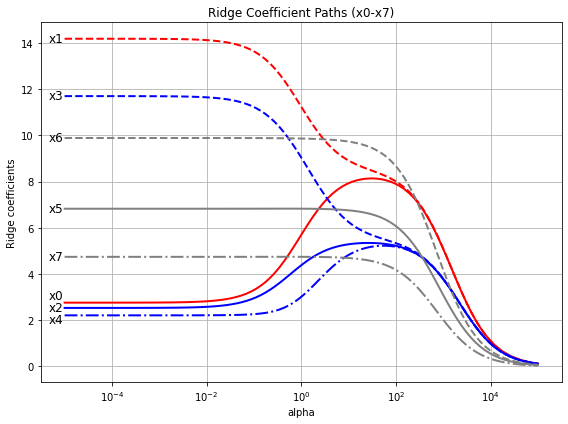

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# 生成一系列 alpha 值
alphas = np.logspace(-5, 5, 100)

# 存储系数
coefs = []

# 对每个 alpha 拟合 Ridge 并记录系数
for a in alphas:
    ridge = Ridge(alpha=a, max_iter=10000)
    ridge.fit(X_train_scaled, Y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# 定义不同变量的线型
linestyles = ["-", "--", "-."]

# 绘图 (只画 x0-x7)
plt.figure(figsize=(8, 6))

for i in range(8):
    if i in [0, 1]:
        color = "red"
        linestyle = linestyles[i]
    elif i in [2, 3, 4]:
        color = "blue"
        linestyle = linestyles[i-2]
    else:
        color = "gray"
        linestyle = linestyles[i-5]
    plt.plot(
        alphas, coefs[:, i],
        color=color,
        linestyle=linestyle,
        linewidth=2,
        label=f"x{i}"
    )

    # 在线的最左边标注变量名
    if i==0: 
        plt.text(
            alphas[0] * 0.95,
            coefs[0, i]+0.3,
            f"x{i}",
            fontsize=12,
            color="black",
            va="center",
            ha="right"
        )
    elif i==4: 
        plt.text(
            alphas[0] * 0.95,
            coefs[0, i]-0.2,
            f"x{i}",
            fontsize=12,
            color="black",
            va="center",
            ha="right"
        )
    else:
        plt.text(
            alphas[0] * 0.95,
            coefs[0, i],
            f"x{i}",
            fontsize=12,
            color="black",
            va="center",
            ha="right"
        )

plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Ridge coefficients")
plt.title("Ridge Coefficient Paths (x0-x7)")
plt.grid(True)
plt.tight_layout()
plt.savefig("Ridge_path.png", bbox_inches="tight")
plt.show()
